# Importing python modules

In [31]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [32]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Importing pre-trained models on ImageNet data

In [33]:
import pretrainedmodels

In [34]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


# Obtaining the settings of Inception v4 on ImageNet and applying modifications to the number of classes

In [35]:
print(pretrainedmodels.pretrained_settings['inceptionv4'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth', 'input_space': 'RGB', 'input_size': [3, 299, 299], 'input_range': [0, 1], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'num_classes': 1000}, 'imagenet+background': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionv4-8e4777a0.pth', 'input_space': 'RGB', 'input_size': [3, 299, 299], 'input_range': [0, 1], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'num_classes': 1001}}


In [36]:
model_name='inceptionv4'
input_size = 299
num_classes=3

In [37]:
import torch.nn as nn

model=pretrainedmodels.__dict__[model_name](1000, pretrained='imagenet')
model.__call__
dim_feats=model.last_linear.in_features
model.last_linear=nn.Linear(dim_feats, num_classes)


In [38]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./data/"


# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [39]:
#Data augmentation and normalization for training
# Just normalization for validation
input_size=299
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val','test']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val','test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [40]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 62068
     Root Location: ./data/train
     Transforms (if any): Compose(
                              RandomResizedCrop(size=(299, 299), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                              RandomHorizontalFlip(p=0.5)
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          )
     Target Transforms (if any): None, 'val': Dataset ImageFolder
     Number of datapoints: 15340
     Root Location: ./data/val
     Transforms (if any): Compose(
                              Resize(size=299, interpolation=PIL.Image.BILINEAR)
                              CenterCrop(size=(299, 299))
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          )
     Target Transforms (if any): None, 

In [41]:
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image

# Assigning index to the classes

In [42]:
image_datasets['train'].class_to_idx

{'edema': 0, 'no_edema': 1, 'uncertain': 2}

In [43]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Optimizing the parameters

In [44]:
# Send the model to GPU
model_ft = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.conv.weight
	 features.0.bn.weight
	 features.0.bn.bias
	 features.1.conv.weight
	 features.1.bn.weight
	 features.1.bn.bias
	 features.2.conv.weight
	 features.2.bn.weight
	 features.2.bn.bias
	 features.3.conv.conv.weight
	 features.3.conv.bn.weight
	 features.3.conv.bn.bias
	 features.4.branch0.0.conv.weight
	 features.4.branch0.0.bn.weight
	 features.4.branch0.0.bn.bias
	 features.4.branch0.1.conv.weight
	 features.4.branch0.1.bn.weight
	 features.4.branch0.1.bn.bias
	 features.4.branch1.0.conv.weight
	 features.4.branch1.0.bn.weight
	 features.4.branch1.0.bn.bias
	 features.4.branch1.1.conv.weight
	 features.4.branch1.1.bn.weight
	 features.4.branch1.1.bn.bias
	 features.4.branch1.2.conv.weight
	 features.4.branch1.2.bn.weight
	 features.4.branch1.2.bn.bias
	 features.4.branch1.3.conv.weight
	 features.4.branch1.3.bn.weight
	 features.4.branch1.3.bn.bias
	 features.5.conv.conv.weight
	 features.5.conv.bn.weight
	 features.5.conv.bn.bias
	 features.6.b

# Model Training

In [45]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val','test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [46]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [47]:

#!CUDA_LAUNCH_BLOCKING=1
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.7469 Acc: 0.7030
val Loss: 0.6983 Acc: 0.7218
test Loss: 0.8689 Acc: 0.6386
Epoch 2/14
----------
train Loss: 0.7382 Acc: 0.7077
val Loss: 0.6786 Acc: 0.7277
test Loss: 0.7225 Acc: 0.6931
Epoch 3/14
----------
train Loss: 0.7258 Acc: 0.7118
val Loss: 0.6708 Acc: 0.7338
test Loss: 0.7946 Acc: 0.6287
Epoch 4/14
----------
train Loss: 0.7179 Acc: 0.7144
val Loss: 0.7464 Acc: 0.7123
test Loss: 0.8452 Acc: 0.6634
Epoch 5/14
----------
train Loss: 0.7119 Acc: 0.7170
val Loss: 0.6720 Acc: 0.7332
test Loss: 0.8653 Acc: 0.6436
Epoch 6/14
----------
train Loss: 0.7087 Acc: 0.7178
val Loss: 0.6768 Acc: 0.7301
test Loss: 0.7405 Acc: 0.7178
Epoch 7/14
----------
train Loss: 0.7073 Acc: 0.7176
val Loss: 0.7437 Acc: 0.7226
test Loss: 1.0989 Acc: 0.5149
Epoch 8/14
----------
train Loss: 0.7043 Acc: 0.7206
val Loss: 0.6933 Acc: 0.7288
test Loss: 1.0359 Acc: 0.5842
Epoch 9/14
----------
train Loss: 0.6977 Acc: 0.7242
val Loss: 0.6828 Acc: 0.7283
test Loss: 0.9778 Acc:

# Saving the model

In [48]:
#Run this if you want to save the model
torch.save(model_ft.state_dict(),'Edema_detect.pth')


In [49]:
#Run this if you want to load the model
model.load_state_dict(torch.load('Edema_detect.pth'))

# Model Evaluation

In [50]:
model.eval()   # Set model to evaluate mode

running_loss = 0.0
running_corrects = 0
all_logits=None
all_labels=None
predictions=[]
true_labels=[]
# Iterate over data.
for inputs, labels in dataloaders_dict['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    all_logits=preds.cpu().numpy()
    all_labels=labels.cpu().numpy()
    predictions.append(all_logits)
    true_labels.append(all_labels)
    
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
epoch_loss = running_loss / len(dataloaders_dict['test'].dataset)
epoch_acc = running_corrects.double() / len(dataloaders_dict['test'].dataset)
print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))

test Loss: 0.8281 Acc: 0.6535


In [51]:
class_names = image_datasets['test'].classes

In [52]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Obtaining model predictions

In [53]:
running_loss=[]
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
                        
            _, preds = torch.max(outputs, 1)

              
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

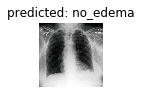

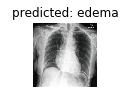

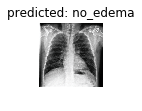

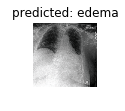

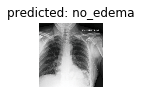

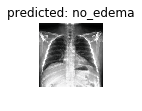

In [54]:
visualize_model(model)

In [55]:
pred_array=np.concatenate(predictions)


In [56]:
lab_array=np.concatenate(true_labels)

In [57]:
lab_array

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0])

# Calculation of Model Metrics

In [58]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import recall_score,accuracy_score

              precision    recall  f1-score   support

           0       0.37      0.95      0.53        42
           1       0.99      0.57      0.73       160
           2       0.00      0.00      0.00         0

    accuracy                           0.65       202
   macro avg       0.45      0.51      0.42       202
weighted avg       0.86      0.65      0.69       202



/home/jupyter-tpisati/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


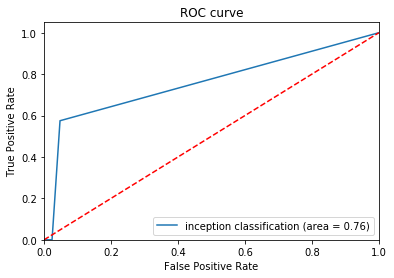

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
print(classification_report(lab_array,pred_array))
Roc_auc = roc_auc_score(lab_array,pred_array)
fpr, tpr, thresholds = roc_curve(lab_array,pred_array)
plt.plot(fpr, tpr, label='inception classification (area = %0.2f)' % Roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve')
plt.show()